In [2]:
import os
import sys
from cheta import fetch
import Ska.Matplotlib
import Chandra.Time
from Ska.tdb import msids
import numpy
import matplotlib.pyplot as plt

In [3]:
#Functions to be used later
#from update_compgradkodak.py
def fill_gaps(ttime, otime, data):
    """
    match the numbers of entries accroding to two time lists
    the data are repeated between two time stamps of the data to be filled
    input:  ttime   --- an array of time to be matched
            otime   --- an array of time of the data
                        len(ttime) > len(otime)
            data    --- an array of data
    output: adata   --- adjusted data
    """
#
#--- convert numpy array to list
#
    ttime = list(ttime)
    data  = list(data)
    otime = list(otime)

    tlen  = len(ttime)
    mlen  = len(otime)

    adata = []
    n     = 0
    chk   = 0
    for m in range(0, tlen):
        if ttime[m] > otime[n]:
            while ttime[m] > otime[n]:
                n += 1
                if n >= mlen:
                    diff = tlen - len(adata)
                    for nk in range(0, diff):
                        adata.append(data[n-1])
                    chk = 1
                    break
                else:
                    if ttime[m] == otime[n]:
                        adata.append(data[n])
                        break
        elif ttime[m] < otime[n]:
            adata.append(data[n])
        else:
            adata.append(data[n])
            n += 1
            if n >= mlen:
                diff = tlen - len(adata)
                for nk in range(0, diff):
                    adata.append(data[n-1])
                chk = 1
        if chk == 1:
            break
#
#--- put back into numpy array
#
    adata = numpy.array(adata)

    return adata

#-------------------------------------------------------------------------------------------
#-- take_sum: take average of the given data                                              --
#-------------------------------------------------------------------------------------------

def take_sum(olist, data, pos, achk=0):
    """
    take average of the given data
    input:  olist   --- a list of data ids
            data    --- a list of data
            pos     --- the position of the data to be used in data[*]
            achk    --- if 0, just retur the sum, if >0, take an average
    output: asum or avg --- asum (achk=0): sum of the values
                            avg  (achk>0): averaged of the values
    """
    asum = 0.0
    tot  = 0.0
    for k in olist:
        try:
            val = data[k][pos]
            if val > 0:
                asum += data[k][pos]
                tot  += 1.0
        except:
            pass

    if achk == 0:
        return asum

    else:
        try:
            avg = asum / tot
        except:
            avg = 'na'

        return avg

#-------------------------------------------------------------------------------------------
#-- compute_hrmaavg: compute hrma temp average                                            --
#-------------------------------------------------------------------------------------------

def compute_hrmaavg(ohrthr, pos):
    """
    compute hrma temp average
    input:  ohrthr  --- a list of ohrthr data lists
            pos     --- the position of the data in the ohrthr[*]
    output: hrmaavg --- hrma temp average
    """
    olist    = list(range(2,14)) + list(range(21,31)) + [33, 36, 37, 42] 
    olist    = olist + list(range(44,48)) + list(range(49,54)) + [55, 56]
    hrmaavg  = take_sum(olist, ohrthr, pos, achk=1)

    return hrmaavg
    

https://github.com/sot/cheta/pull/261/files#L462

According to the wide conversion PR in cheta in Line 462
Transition at "2024:102:11:49:35" for a set of the OHRTHR heaters then
Transition at "2024:102:11:52:19" for another set of the OHRTHR heaters plus the 4OAVHRMT msid
Which is the OBC computed average. 

In [4]:
start = "2024:102:11:40:35"
stop = "2024:102:11:59:19"

In [5]:
#From the Git pull
d = "44 02 21 45 03 22 46 23 04 47 49 24 05 06 25 50 51 07 26 27 29 30".split()
e =  "08 09 10 11 12 13 14 18 20 31 33 34 35 36 37 41 42 43 52 53 54 55 56 57 58 62".split()
d.sort()
e.sort()
d = [int(i) for i in d]
e = [int(i) for i in e]

In [6]:
#Selection of OHRTHR heaters used but OBC (sourced by Christian Anderson)
OBC_sel = list(range(2,13+1)) + list(range(21,27+1)) + [29,30,33,36,37,42]
OBC_sel += list(range(44,47+1)) + list(range(49,53+1)) + [55,56]

First we'll discuss the difference in transitioning the , due to the split in which the OHRTHR values are transitioned in cheta, only a portion of the MSID's listed as used by the OBC were in place at that time.

In [7]:
print(f"Full OBC: {OBC_sel}")
print(f"Portion Unaltered during transition: {set(OBC_sel).difference(set(d))}")
print(f"Portion unaltered by second stage: {set(OBC_sel).difference(set(d + e))}")

Full OBC: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 21, 22, 23, 24, 25, 26, 27, 29, 30, 33, 36, 37, 42, 44, 45, 46, 47, 49, 50, 51, 52, 53, 55, 56]
Portion Unaltered during transition: {33, 36, 37, 8, 9, 10, 11, 12, 13, 42, 52, 53, 55, 56}
Portion unaltered by second stage: set()


Based on the data fetched by cheta for this time period, the OBC computed average appears to reflect this mode of transition as well. However, another factor of this transition from Narrow to Wide is that the IPCL acorn calibration changed as well. Previously, a byte number for any of the narrow OHRTHR heaters would be translated from a (0-255) count range to a analog temperature with a polynomial calibration.
https://docs.google.com/document/d/1CHBAz7BM8b_16G7t4KieP6XsxhZfBgy_PVs_u1HmX_0/edit?usp=sharing
However, the wide OHRTHR heaters translate the byte to an analog temperature with a point-pair calibration, which results in the acorn specific values being slightly different when fetched.

As such, reflecting each stage of how the data numbers are processed into different temperature values will require analysis of the original byte numbers, knowledge of the exact OBC transitition times ( assumed to be the same as viewed in the Cheta PR).
Suffice to say, the approach used by Cheta is to map the new wide values of the MSID's to the old narrow values for backwards compatability, and they scaled well during this transition time which means it was not the cause of our discontinuity.

# Cheta Values During Transition

In [8]:
print(f"START: {start}")
print(f"STOP: {stop}")

START: 2024:102:11:40:35
STOP: 2024:102:11:59:19


4OAVHRMT: [296.28836 296.27658 296.28836 296.28836 296.27658 296.27658 296.28836
 296.28836 296.27658 296.27658 296.27658 296.27658 296.28836 296.28836
 296.27658 296.27658 295.32526 295.32526 295.32526 295.32526 295.32526
 296.24332 296.24332 296.24332 296.1833  296.24332 296.24332 296.24332
 296.24332 296.24332 296.24332 296.24332 296.24332 296.24332]


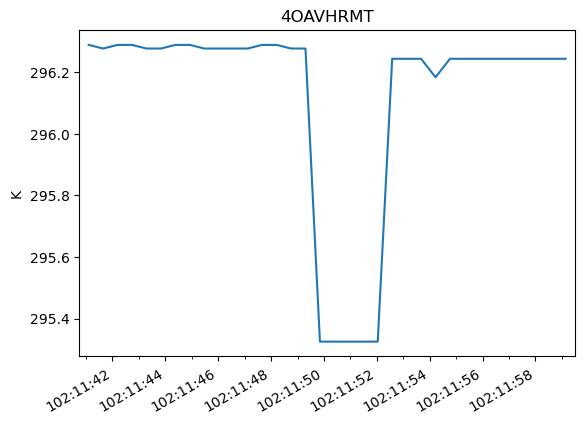

In [9]:
pre_computed_narrow   = fetch.MSID("4OAVHRMT", start, stop)
print(f"4OAVHRMT: {pre_computed_narrow.vals}")
pre_computed_narrow.plot()

4OAVHRMT_WIDE: [305.35764 305.2872  305.35764 305.35764 305.2872  305.2872  305.35764
 305.35764 305.2872  305.2872  305.2872  305.2872  305.35764 305.35764
 305.2872  305.2872  299.78165 299.78165 299.78165 299.78165 299.78165
 296.24332 296.24332 296.24332 296.1833  296.24332 296.24332 296.24332
 296.24332 296.24332 296.24332 296.24332 296.24332 296.24332]


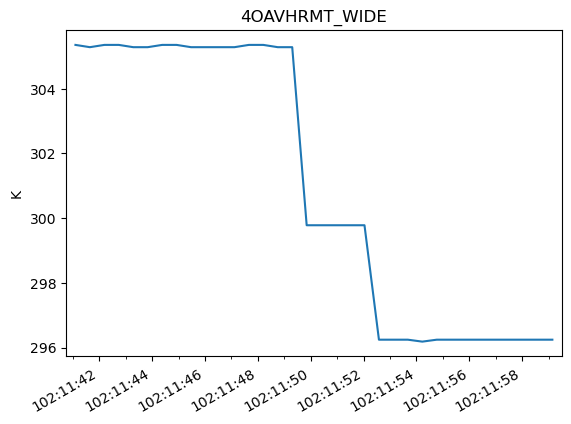

In [10]:
pre_computed_wide   = fetch.MSID("4OAVHRMT_WIDE", start, stop)
print(f"4OAVHRMT_WIDE: {pre_computed_wide.vals}")
pre_computed_wide.plot()

Notice that by the end, both the wide and narrow verison map to the same values.

OHRTHRO3: [295.33383 295.33383 295.3455  295.3455  295.3455  295.3455  295.33383
 295.3455  295.3455  295.3455  295.33383 295.33383 295.33383 295.3455
 295.3455  295.3455  295.28268 295.28268 295.28268 295.28268 295.28268
 295.28268 295.28268 295.28268 295.28268 295.28268 295.28268 295.28268
 295.28268 295.28268 295.28268 295.28268 295.28268 295.28268]


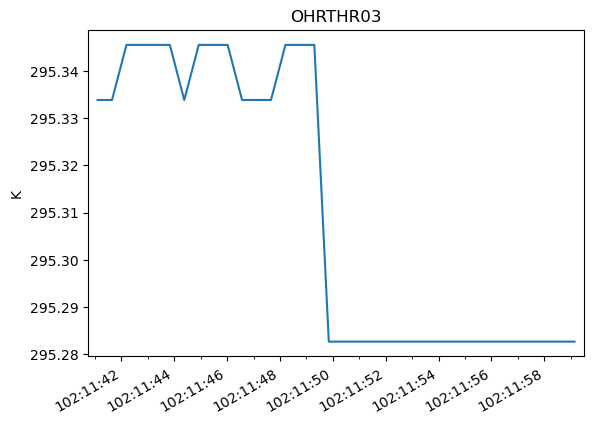

In [11]:
ohrthr03_narrow   = fetch.MSID("OHRTHR03", start, stop)
print(f"OHRTHRO3: {ohrthr03_narrow.vals}")
ohrthr03_narrow.plot()

OHRTHRO3_WIDE: [299.9114  299.9114  299.97626 299.97626 299.97626 299.97626 299.9114
 299.97626 299.97626 299.97626 299.9114  299.9114  299.9114  299.97626
 299.97626 299.97626 295.28268 295.28268 295.28268 295.28268 295.28268
 295.28268 295.28268 295.28268 295.28268 295.28268 295.28268 295.28268
 295.28268 295.28268 295.28268 295.28268 295.28268 295.28268]


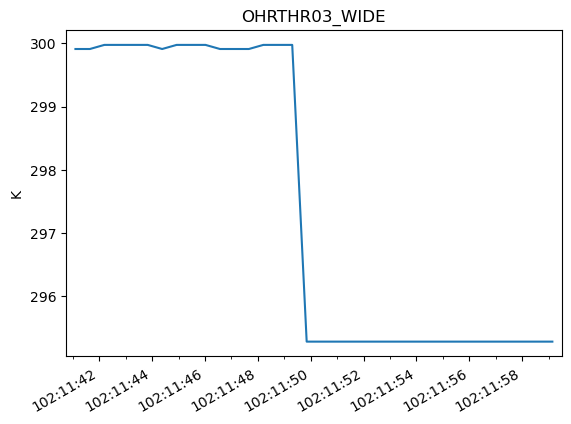

In [12]:
ohrthr03_wide   = fetch.MSID("OHRTHR03_WIDE", start, stop)
print(f"OHRTHRO3_WIDE: {ohrthr03_wide.vals}")
ohrthr03_wide.plot()

# Difference in MTA computed HRMAAVG (cause of discontinuity)

The selection used by OBC in calculating the 4OAVHRMT average is very similar to the selection of OHRTHR heaters used by MTA for HRMAAVG, aside from one key difference.

In [13]:
#MTA slection for the HRMAAVG calcualted value (sourced from MTA_limit_trends/Deposit/update_compgradkodak.py)
MTA_sel = list(range(2,14)) + list(range(21,31)) + [33, 36, 37, 42] 
MTA_sel += list(range(44,48)) + list(range(49,54)) + [55, 56]

In [14]:
set(MTA_sel).difference(set(OBC_sel))

{28}

Therefore on the MTA side, we include the OHRTHR28 incorrectly when calculating the average

In [15]:
msids.find("OHRTHR28")

[<MsidView msid="OHRTHR28" technical_name="INVALID: TELESCOPE THERMISTOR DATA: HRMA CH 27">]

https://cxc.cfa.harvard.edu/mta/MSID_Trends/Hrmaheaters/Ohrthr28/ohrthr28_mid_static_short_plot.html

This MSID is currently listed as invalid, not to mention that around the time of the WIDE conversion, it carried a significant discontinuity from values around 750 K dropping down to 550 under the new acorn calibration (already a significant contributor compared to other OHRTHR heaters typically around 300 K). I'm unsure when this MSID became invalid but it appears as though the full range of data is around 750K so it's possible it was always invalid.

It's also worth noting that our selection process for OHRTHR data involves putting the fetch result data
into a list of lists like so.

In [16]:
#We depend on the time scale used in fetching 4rt data first
empty  = [0]
#
#--- extract  4rt*** data
#
rt7  = []
for k  in range(0, 12):
    if k < 10:
        msid = '4rt70' + str(k) + 't'
    else:
        msid = '4rt7'  + str(k) + 't'

    try:
        out   = fetch.MSID(msid, start, stop)
        data  = out.vals
        ttime = out.times
        tlist = list(ttime)
        rt7.append(data)
    except:
        rt7.append(empty)
#
#--- extract 4rt575t separately
#
out    = fetch.MSID('4rt575t', start, stop)
rt575  = out.vals
#
#--- create empty array and initialize ohrthr and oobthr lists
#
tlen   = len(ttime)
empty  = numpy.zeros(tlen)

In [17]:
for i in range(len(ttime)):
    print(f"{Chandra.Time.DateTime(ttime[i]).date} - {rt575[i]}")

2024:102:11:41:06.091 - 310.34075927734375
2024:102:11:41:38.891 - 310.34075927734375
2024:102:11:42:11.691 - 310.34075927734375
2024:102:11:42:44.491 - 310.34075927734375
2024:102:11:43:17.291 - 310.34075927734375
2024:102:11:43:50.091 - 310.34075927734375
2024:102:11:44:22.891 - 310.34075927734375
2024:102:11:44:55.691 - 310.34075927734375
2024:102:11:45:28.491 - 310.34075927734375
2024:102:11:46:01.291 - 310.34075927734375
2024:102:11:46:34.091 - 310.34075927734375
2024:102:11:47:06.891 - 310.34075927734375
2024:102:11:47:39.691 - 310.34075927734375
2024:102:11:48:12.491 - 310.34075927734375
2024:102:11:48:45.291 - 310.34075927734375
2024:102:11:49:18.091 - 310.34075927734375
2024:102:11:49:50.891 - 310.34075927734375
2024:102:11:50:23.691 - 310.34075927734375
2024:102:11:50:56.491 - 310.34075927734375
2024:102:11:51:29.291 - 310.34075927734375
2024:102:11:52:02.091 - 310.34075927734375
2024:102:11:52:34.891 - 310.34075927734375
2024:102:11:53:07.691 - 310.34075927734375
2024:102:11

Then the ohrthr list of lists is initialized based on the results of that fetch

In [18]:
ohrthr = [empty]
oobthr = [empty]

print(f"{ohrthr}")
#
#--- fill them up
#
for k in range(1, 65):
    if k < 10:
        msid = 'ohrthr0' + str(k)
    else:
        msid = 'ohrthr'  + str(k)
    try:
        out   = fetch.MSID(msid, start, stop)
        data  = out.vals
        print(len(data))
        print(f"{msid} - {data}")
        otime = out.times
#
#--- since 4rt arrays are 36 time dense, match the ohrthr and oobtrhr 
#--- by filling the gaps between
#
        adata = fill_gaps(ttime, otime, data)

        ohrthr.append(adata)
    except:
        ohrthr.append(empty)

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
34
ohrthr01 - [512. 512. 512. 512. 512. 512. 512. 512. 512. 512. 512. 512. 512. 512.
 512. 512. 512. 512. 512. 512. 512. 512. 512. 512. 512. 512. 512. 512.
 512. 512. 512. 512. 512. 512.]
34
ohrthr02 - [295.2241  295.37534 295.3171  295.28223 295.25894 295.2357  295.39865
 295.32877 295.29385 295.27057 295.2473  295.2241  295.37534 295.3171
 295.28223 295.25894 295.10254 295.40274 295.28268 295.3427  295.28268
 295.3427  295.28268 295.3427  295.28268 295.3427  295.28268 295.22263
 295.28268 295.28268 295.3427  295.28268 295.3427  295.28268]
34
ohrthr03 - [295.33383 295.33383 295.3455  295.3455  295.3455  295.3455  295.33383
 295.3455  295.3455  295.3455  295.33383 295.33383 295.33383 295.3455
 295.3455  295.3455  295.28268 295.28268 295.28268 295.28268 295.28268
 295.28268 295.28268 295.28268 295.28268 295.28268 295.28268 295.28268
 29

34
ohrthr30 - [296.96774 296.96774 296.96774 296.96774 296.96774 296.96774 296.96774
 296.96774 296.96774 296.96774 296.96774 296.96774 296.97974 296.97974
 296.97974 296.97974 296.90378 296.90378 296.90378 296.90378 296.90378
 296.90378 296.90378 296.90378 296.90378 296.90378 296.90378 296.90378
 296.90378 296.90378 296.90378 296.90378 296.90378 296.90378]
34
ohrthr31 - [296.28674 296.28674 296.28674 296.28674 296.28674 296.28674 296.28674
 296.28674 296.28674 296.28674 296.28674 296.28674 296.28674 296.28674
 296.28674 296.28674 296.28674 296.28674 296.28674 296.28674 296.28674
 296.24332 296.24332 296.24332 296.24332 296.24332 296.24332 296.24332
 296.24332 296.30338 296.30338 296.30338 296.30338 296.24332]
34
ohrthr32 - [59. 59. 59. 58. 59. 58. 59. 59. 59. 59. 59. 59. 59. 59. 59. 59. 59. 59.
 59. 59. 59. 59. 59. 59. 58. 58. 59. 59. 59. 59. 59. 59. 59. 59.]
34
ohrthr33 - [296.4187 296.4187 296.4187 296.4187 296.4187 296.4187 296.4187 296.4187
 296.4187 296.4187 296.4187 296.4187 296

34
ohrthr60 - [296.30338 296.30338 296.30338 296.30338 296.30338 296.30338 296.30338
 296.30338 296.30338 296.30338 296.30338 296.30338 296.30338 296.30338
 296.30338 296.30338 296.30338 296.30338 296.30338 296.30338 296.30338
 296.30338 296.30338 296.30338 296.30338 296.30338 296.30338 296.30338
 296.30338 296.30338 296.30338 296.30338 296.30338 296.30338]
34
ohrthr61 - [296.24332 296.24332 296.24332 296.24332 296.24332 296.24332 296.24332
 296.24332 296.24332 296.24332 296.24332 296.24332 296.24332 296.24332
 296.24332 296.24332 296.24332 296.24332 296.24332 296.24332 296.24332
 296.24332 296.24332 296.24332 296.24332 296.24332 296.24332 296.24332
 296.24332 296.24332 296.24332 296.24332 296.24332 296.24332]
34
ohrthr62 - [295.76382 295.76382 295.76382 295.76382 295.76382 295.76382 295.76382
 295.76382 295.76382 295.76382 295.76382 295.76382 295.76382 295.76382
 295.76382 295.76382 295.76382 295.76382 295.76382 295.76382 295.76382
 295.6429  295.6429  295.6429  295.6429  295.6429  29

Therefore, we get a list of data, indexed by the OHRTHR number, in which the zeroth index is flled with dummy zeroes. We then compute various temeprature averages using this data set.

In [19]:
#
#--- now compute each quantity for the given time period
#
hrmaavg         = []
#
#--- save time stamp separately for each data   
#
t_hrmaavg       = []

for k in range(0, tlen):
    out = compute_hrmaavg(ohrthr, k )
    if out != 'na':
        hrmaavg.append(out)
        t_hrmaavg.append(tlist[k])

TIME: [829222935.2749603, 829222968.0749624, 829223000.8749646, 829223033.6749667, 829223066.4749688, 829223099.274971, 829223132.0749731, 829223164.8749752, 829223197.6749773, 829223230.4749795, 829223263.2749816, 829223296.0749837, 829223328.8749858, 829223361.674988, 829223394.4749901, 829223427.2749922, 829223460.0749943, 829223492.8749965, 829223525.6749986, 829223558.4750007, 829223591.2750028, 829223624.075005, 829223656.8750072, 829223689.6750093, 829223722.4750113, 829223755.2750136, 829223788.0750157, 829223820.8750178, 829223853.67502, 829223886.4750221, 829223919.2750242, 829223952.0750263, 829223984.8750285, 829224017.6750306]

VALUE: [308.82636487806167, 308.82384594066724, 308.82416843723604, 308.85560319230365, 308.8530850797086, 308.84587880727406, 308.8578293259079, 308.85624488624364, 308.84965143976984, 308.8468339249894, 308.8515435296136, 308.84745417414484, 308.8798432221284, 308.88645151499156, 308.8823547363281, 308.87451419314823, 303.428448651288, 303.4498662

(((matplotlib.dates.MinuteLocator,
   {'byminute': [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56]},
   '%j:%H:%M',
   matplotlib.dates.MinuteLocator,
   {}),),
 <Figure size 640x480 with 1 Axes>,
 <Axes: >)

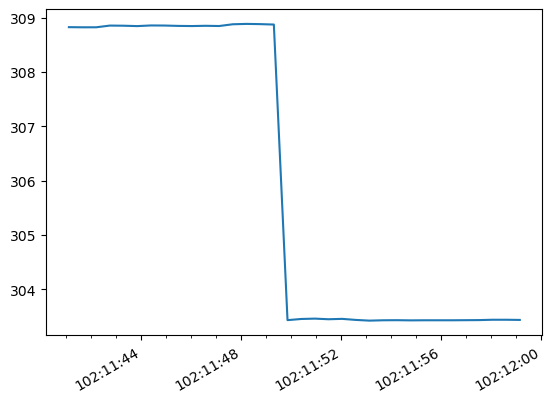

In [20]:
print(f"TIME: {t_hrmaavg}")
print()
print(f"VALUE: {hrmaavg}")
Ska.Matplotlib.plot_cxctime(t_hrmaavg, hrmaavg)

Because we incorrectly use the invalid OHRTHR28 msid which has a large discontinuity at this time point, our calculated average carried that discontinuity over as well. If we were to repeat the process used in the compute_hrmaavg function above, but use the OBC selection of msid, we obtain...

In [21]:
OBC_hrmaavg = []
OBC_t_hrmaavg = []
for k in range(0, tlen):
    #out = compute_hrmaavg(ohrthr, k )
    out  = take_sum(OBC_sel, ohrthr, k, achk=1)
    if out != 'na':
        OBC_hrmaavg.append(out)
        OBC_t_hrmaavg.append(tlist[k])

TIME: [829222935.2749603, 829222968.0749624, 829223000.8749646, 829223033.6749667, 829223066.4749688, 829223099.274971, 829223132.0749731, 829223164.8749752, 829223197.6749773, 829223230.4749795, 829223263.2749816, 829223296.0749837, 829223328.8749858, 829223361.674988, 829223394.4749901, 829223427.2749922, 829223460.0749943, 829223492.8749965, 829223525.6749986, 829223558.4750007, 829223591.2750028, 829223624.075005, 829223656.8750072, 829223689.6750093, 829223722.4750113, 829223755.2750136, 829223788.0750157, 829223820.8750178, 829223853.67502, 829223886.4750221, 829223919.2750242, 829223952.0750263, 829223984.8750285, 829224017.6750306]

VALUE: [296.29376390245227, 296.29117499457465, 296.29150644938153, 296.2960366143121, 296.29344855414496, 296.28604210747613, 296.29832458496094, 296.29669613308374, 296.28991953531903, 296.28702375623914, 296.291864183214, 296.2876612345378, 296.2931722005208, 296.29996405707465, 296.2957534790039, 296.2876951429579, 296.24590555826825, 296.267918

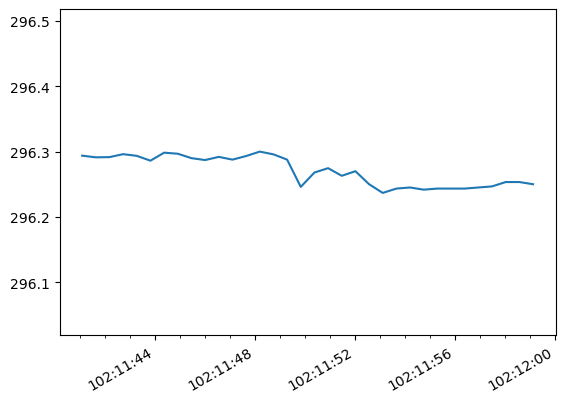

In [22]:
print(f"TIME: {OBC_t_hrmaavg}")
print()
print(f"VALUE: {OBC_hrmaavg}")
ticklocs, fig, ax = Ska.Matplotlib.plot_cxctime(OBC_t_hrmaavg, OBC_hrmaavg)
Ska.Matplotlib.set_min_axis_range(ax,0.5)

Once the correct selection is taken, the transition between narrow and wide versions of the OHRTHR heaters, our plot becomes continuous as expected.